# Fractals

Generation of Mandelbrots, Multibrots, and other fractals with Python

In [101]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import math
import random
import typing
import inspect

In [2]:
class Point:
    def __init__(self, pos, p=8):
        self.pos = np.array(pos, dtype=float)
        self.precision = p
        
    def move(self, delta):
        self.pos += np.array(delta)
    
    def rotate(self, a, theta, rad=False):
        theta = float(theta)
        if not rad:
            theta = theta * math.pi / 180
        rotation_matrix = [
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ]
#         print(rotation_matrix)
#         self.pos *= rotation_matrix
        self.move(-a.pos)
        self.pos = np.dot(self.pos, rotation_matrix)
        self.move(a.pos)
        self.pos = self.pos.round(self.precision)
        return self
    
    def __call__(self):
        return self.pos
    
    def print(self):
        print(self)
        return self
        
    def __str__(self):
        return 'Point ' + str(self.pos)
        

p = Point([0, 2])
t = Point([0, 1])
p.print()
t.print()
p.rotate(t, 90).pos

Point [0. 2.]
Point [0. 1.]


array([1., 1.])

In [3]:
class Line:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def move(self, delta):
        for p in [self.a, self.b]:
            p.move(delta)
        return self
            
    def rotate(self, *args, **kwargs):
        for p in [self.a, self.b]:
            p.rotate(*args, **kwargs)
        return self
    
    def divide(self, n=1):
#         return [Line(Point(np.average([self.a, self.b], weights=[]))) for i in range(n)]
        sections = []
        for i in range(n):
            a_ = np.average([self.a(), self.b()], weights=[i, n-i], axis=0)
            b_ = np.average([self.a(), self.b()], weights=[i+1, n-i-1], axis=0)
            s = Line(
                Point(a_),
                Point(b_)
            )
            sections.append(s)
        return sections
        
    def __str__(self):
        return 'Line\n\t' + '\n\t'.join(str(v) for v in [self.a, self.b])
    
# TODO: geometric figure names/symbols
# TODO: symbolic position data (e.g., 1/3, sqrt(2)+1)

l = Line(
    Point([0, 2]),
    Point([0, 1])
)
# l.rotate(t, 90).a.pos
print(l.divide(3)[2])

Line
	Point [0.         1.66666667]
	Point [0. 2.]


In [4]:
class Polygon:
    def __init__(self, vertices=None):
        if not vertices:
            vertices = []
        self.vertices = vertices
        self.v = self.vertices
        
    def __str__(self):
        return 'Polygon\n\t' + '\n\t'.join(str(v) for v in self.v)

In [5]:
class RegularPolygon(Polygon):
    def __init__(self, r=1, n=4, c=None):
        super().__init__()
        self.v.append(Point([0, r]))
        if not c:
            c = Point([0, 0])
        self.center = c
        for i in range(n-1):
            self.v.append(Point(self.v[-1].pos).rotate(c, 360 / n))
            
r = RegularPolygon()
print(r)

Polygon
	Point [0. 1.]
	Point [1. 0.]
	Point [ 0. -1.]
	Point [-1. -0.]


In [6]:
type(lambda x:x)

function

[-2, -1] [0]
14882


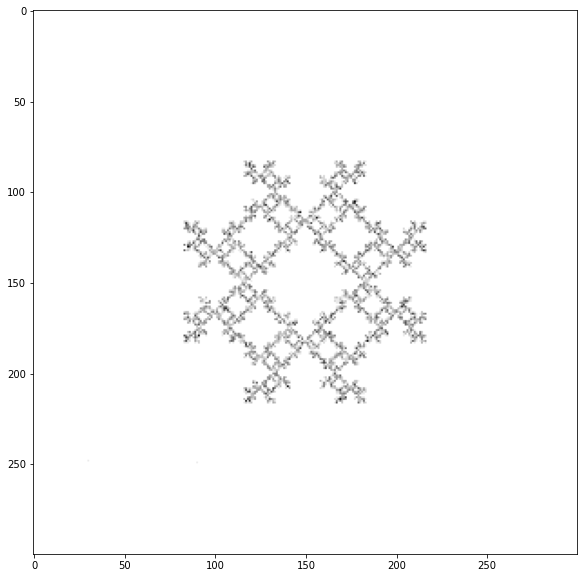

In [260]:
class ChaosGame:
    def __init__(self, n=3):
        if type(n) in [tuple, list]:
            n = random.randint(*n)
        self.shape = RegularPolygon(n=n)
        self.points = []
        self.vertices = [0] * 10
        self.compute = 0
        self.n = n
        
    def dist(self, a, b):
        d = abs(a - b)
        return min(d, self.n-d)
    dist.info = 'Calculate the distance between elements of a ring; e.g., vertices of a polygon'
        
    def create_rule(self, n, m):
#         return lambda x, f: f(*n) not in m
        return lambda x, f: f(*[x[i] for i in n]) not in m
        
    def generate(self, x=10, y=0.5, rule=None):
        p = np.random.uniform(-5, 5, self.shape.center.pos.shape)
#         if rule:
#             self.vertices = [-1] * abs(min(rule))

        if rule == 'random':
            j = random.choices(list(range(-5, -1)), k=1) + [-1]
            k = random.choices(list(range(0, self.n // 2 + 1)), k=random.randint(0,3))
            j, k = [-2, -1], [0]
#             rule_gen = lambda n, m: (lambda x, f: f(*n) not in m)
            rule = self.create_rule(j, k)
            print(j, k)
        self.rule = rule
            
        for i in range(x):
#             random.choice(self.shape.v)
            v = random.randint(0, len(self.shape.v)-1)
            rule_eval = False
            if rule:
                if type(rule) in [list, tuple]:
                    rule_eval = !(any(self.vertices[i] == v for i in rule)
                elif callable(rule):
                    rule_eval = rule(self.vertices + [v], self.dist)
#                     print(self.vertices + [v], rule_eval)
#                     try:
#                         rule_eval = rule(self.vertices + [v], self.dist)
#                     except:
#                         rule_eval = True
#             else:
#                 rule_eval = True
            
            if rule_eval:
                p = np.average([p, self.shape.v[v].pos], axis=0, weights=[1-y, y])
                self.compute += 1
                self.points.append(p)
            self.vertices.append(v)
        return self
    generate.info = 'Simulate the "chaos game", generating a series of points according to the given rules'
    
    def render(self, r=100, coloring=''):
        canvas = np.zeros([r, r])
        points_array = np.interp(np.array(self.points), [-1.5, 1.5], [0, r])
        points_array = points_array.astype(int).clip(0, r-1)
        for i, p in enumerate(points_array):
            if coloring == 'index':
                c = i
            elif coloring == 'vertex':
                c = self.vertices[i]
            else:
                c = 0.01
            canvas[tuple(p.round())] += c
        return np.flip(canvas.T)
    render.info = 'Convert the computed points to a displayable image'

r = lambda x, f: f(x[-1], x[-2]) not in [2]
g = ChaosGame((3, 8)).generate(x=20000, y=0.5, rule='random')
print(g.compute)
plt.figure(figsize=(10, 10))
plt.imshow(g.render(300), cmap='binary')
# g.points
# TODO: rule for "point cannot be opposite of another"
# TODO: reverse evaluation
# TODO: coloring points by distance to adjacent points

In [238]:
g.vertices[-10:]

[1, 1, 4, 2, 2, 5, 0, 3, 2, 3]

In [142]:
g.rule([0, 1, 3, 3, 4, 2], g.dist)
# inspect.getsource(g.rule)
# g.rule??
inspect.signature(g.rule)

<Signature (x, f)>

10000

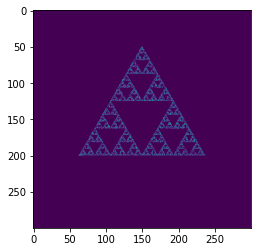

In [87]:
class SierpinskiTriangle(ChaosGame):
    def __init__(self):
        super().__init__(3)
        
t = SierpinskiTriangle()
plt.imshow(t.generate(10000).render(300))
t.compute

In [856]:
# TODO: prior selected point weights

In [207]:
abs(complex(-5, -10))

11.180339887498949

In [344]:
def t():
    t.a = 5
t.a

AttributeError: 'function' object has no attribute 'a'

In [357]:
Fractal.norm.params

7

In [379]:
test = list[int, Fractal]
(list, (int,))
test
# __annotations__
str(test)
vars(test)
typing.get_origin(test)
typing.get_args(test)

(int, __main__.Fractal)

In [466]:
f8 = Fractal()
f8.scale(-3, 0, 0.01)
np.interp(-0.5, [-1, 1], [0, 30])
np.interp([-2.9, 1.4], [-2, 2], [0, 50])

array([ 0. , 42.5])

In [480]:
(0, 0) in [int]

False

In [640]:
def tile(ims, n, d):
    ims = np.reshape(ims, [*n, *d])
    combined = np.concatenate(np.concatenate(ims, axis=2), axis=0)
    return combined

log = math.log
class Fractal:
    info = 'A generic fractal wrapper; describes a mathematical object with self-similar properties'
    
    def __init__(
            self,
            b=10e5,
            n=20,
            o=(0., 0.),
            m=4,
            r=(100, 200),
            frame=None,
            radius=2,
            point_spacing=0.1,
            randomizer=random.uniform,
            **kwargs
        ):
        if type(r) is int:
            r = [r] * 2
        if type(o) in [int, float]:
            o = [o] * 2
        
        self.r = np.array(r)
        self.o = np.array(o)
        self.randomizer = randomizer
        defaults = {
            'z': 0,
            'd': 2
        }
#         kwargs |= defaults
        for k, v in defaults.items():
            if k not in kwargs:
                kwargs[k] = v
        
        for param in ['z', 'd']:
            value = kwargs[param]
            if type(value) in [tuple, list]:
                if len(value) == 2:
                    standard_value = randomizer(*value)
                else:
                    standard_value = random.choice(value)
            else:
                standard_value = value
            
            setattr(self, param, standard_value)
#         self.z = z
#         self.d = d
        self.b = b
        self.m = m
        self.n = n
        
        self.radius = radius
        g = self.radius
        if not frame:
            frame = [[-g, g], [-g, g]]
        self.frame = np.array(frame)# + self.o
        self.f1, self.f2 = self.frame
#         m?

        self.point_spacing = point_spacing
        self.image_size = np.array(np.array([g*2, g*2]) / self.point_spacing, dtype=int)
        print(self.f1)
#         self.image_size = list(map(round, self.image_size))
        self.width, self.height = self.image_size
        
#         self.generate()
        
    def generate(self):
        imsize = self.image_size
        self.canvas = np.zeros(imsize)
        self.iterations = np.zeros(imsize)
#         for x, y in np.ndindex(self.canvas.shape):
        x1, x2, y1, y2 = *self.f1, *self.f2
        ps = self.point_spacing
        points = np.mgrid[x1:x2:ps, y1:y2:ps].reshape(2,-1).T
        for coordinate in points:
            z_ = self.z
#             c = (complex(y, x) / self.r[0] + complex(*self.o)) * self.m
            x, y = coordinate
            c = complex(y, x)
            for i in range(self.n):
                z_ = z_ ** self.d + c
                if abs(z_) > self.b:
#                     index = list(map(round, coordinate * 10))
                    coord_mapping = np.interp(coordinate, [x1, x2], [0, self.width-1])
#                     index = list(map(round, coord_mapping))
                    index = tuple(map(math.floor, coord_mapping))
    #                 canvas[x, y] += i
                    self.canvas[index] = self.norm(abs(z_), i)
#                     self.canvas[index] = i
                    self.iterations[index] = i
                    break
        it = self.iterations
        ca = self.canvas
#         self.canvas = self.scale(self.canvas, it.min(), it.max())
        self.canvas = np.interp(self.canvas, [ca.min(), ca.max()], [it.min(), it.max()])
        self.canvas = self.canvas ** (1/2)
#         print(self.canvas)
        return self.canvas

    def norm(self, x, i):
        norm.params = 7
    #     print(x)
        if x == 0:
            y = 0
        else:
            y = i + 1 - log(abs(log(x))) / log(2)
        return y
#     self.norm.params = 7
#     setattr(self.norm, 'params', 7)
#     norm.params = 7

    def scale(self, x, a, b):
        #return (x - a) / (b - a)
        pass
    scale.info = 'Map a value to a new range based on a minimum and maximum'
    scale.params = [
        ('x', [int, float, np.ndarray], 'The value to map'),
        ('a', [int, float], 'The minimum value of the target range'),
        ('b', [int, float], 'The maximum value of the target range')
    ]
    scale.returns = ('original')
    
    def render(self):
        points = self.generate()
        image = points
        return image
    
    def display(self, cmap=plt.colormaps()):
        if type(cmap) in [list, tuple]:
            cmap = random.choice(cmap)
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot()
        image = self.render()
        ax.imshow(image, cmap=cmap)
        plt.axis('off')
        return fig, ax
    
    def find_regions(self, func=np.var, num=5):
        self.generate()
        blocks = []
        w, h = np.array(self.r / num, dtype=int)
        for a in range(num):
            for b in range(num):
                block = self.canvas[a*h: (a+1)*h, b*w: (b+1)*w]
                variance = func(block)
                blocks.append([a, b, w, h, variance])
        return blocks
    
    def autozoom(self):
        region = self.find_regions()
        region.sort(key=lambda x: x[-1], reverse=True)
        region = region[0]
        a, b, w, h, v = region
        region = self.canvas[a*h: (a+1)*h, b*w: (b+1)*w]
        return region
    autozoom.info = 'Automatically find a region of interest and pan/zoom the frame to this area'
    autozoom.params = []
    
    def __call__(self):
        return self.display()



[-2  2]


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

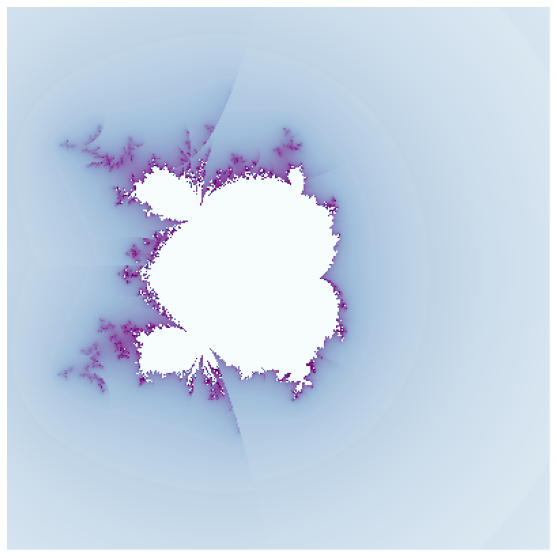

In [766]:
class FractalSet:
    def __init__(self, **kwargs):
        self.fractals = []
#         w = {a:b for (a, b) in kwargs.items() if type(b[0]) in [int, float]}
        w = {}
        self.fixed = {}
        for a, b in kwargs.items():
#             if type(b[0]) in [int, float]:
#             if len(b) == 3:
            if a not in 'r' and type(b) in [list, tuple]:
                if len(b) == 2:
                    b.append(kwargs['q'])
                w[a] = b
            elif a not in 'q':
                self.fixed[a] = b
        self.mdims = [b[-1] for a, b in w.items()]
        self.params = product(*[np.linspace(*b) for a, b in w.items()])
    
    def render(self, **kwargs):
        for p in self.params:
            self.fractals.append(generate(*p, **self.fixed))
        composite = self.fractals
        if 'axes' in kwargs and kwargs['axes']:
            print(kwargs['axes'][0])
            composite = kwargs['axes'][0](self.fractals, axis=0)
            self.mdims = [1, 1]
        composite = tile(composite, self.mdims, self.fixed['r'])
        return composite
    
    def __call__(self, **kwargs):
        return self.render(**kwargs)
    
# f = generate(r=(500, 1000), b=10, n=30, o=(-1, -0.5), m=2)
# f = Fractal(r=(50, 50), b=10, n=30, o=(-1, -0.5), m=2)
# f = FractalSet(z=[0, 1.5], d=[1, 5], r=[200]*2, q=10)(axes=[])
# print(f.find_regions())
# block = f.autozoom()
# f_ = f()
# ax.imshow(f, cmap='plasma')
# ax.imshow(block)
# plt.axis('off')
# list or dict for params?

f = Fractal(z=(-0.5, 0.5), d=(1.5, 3), b=10, n=30, r=(80, 80), o=(-0.1, 0.01), m=2, radius=2, point_spacing=0.01)
f()

# TODO: multicolored fractals

In [765]:
np.var(np.random.uniform(0, 1, [5, 5, 3]))

0.08738764054317584

In [666]:
f.generate()

array([[1.07167488, 1.07313977, 1.0746012 , ..., 0.86930175, 0.86763428,
        0.        ],
       [1.07412817, 1.07560302, 1.07707444, ..., 0.87065883, 0.86898471,
        0.        ],
       [1.07658934, 1.07807425, 1.07955575, ..., 0.87201485, 0.87033405,
        0.        ],
       ...,
       [1.07412817, 1.07560302, 1.07707444, ..., 0.87065883, 0.86898471,
        0.        ],
       [1.07167488, 1.07313977, 1.0746012 , ..., 0.86930175, 0.86763428,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])